In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# derivative
# h=0.00001
# x=2/3
# (f(x+h)-f(x))/h

In [2]:
class Value:
  def __init__(self,data,_children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data+other.data, (self,other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out


  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data*other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self,other):
    # assert isinstance(other, (int,float)), 'only int/float is supported'

    # production way to write assert code using if raise
    if not isinstance(other, (int,float)):
      # raise Exception('only int/float is supported') # use Exception when don't know the exception type
      raise TypeError(f'only int/float is supported not {type(other)}')

    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += (other*(self.data**(other-1))) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def __truediv__(self,other):# self/other
    return self * other**-1

  def __rtruediv__(self,other):# other/self
    return other * self**-1

  def __radd__(self,other):#other + self
    return self + other

  def __rmul__(self,other): #other * self
    return self * other

  def __neg__(self): # -self
    return self * (-1)

  def __sub__(self,other): #self-other
    return self + (-other)

  def __rsub__(self,other):
    return other + (-self)


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [3]:
a=Value(2.0)
b = Value(4.0)
a-b


Value(data = -2.0)

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [5]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()

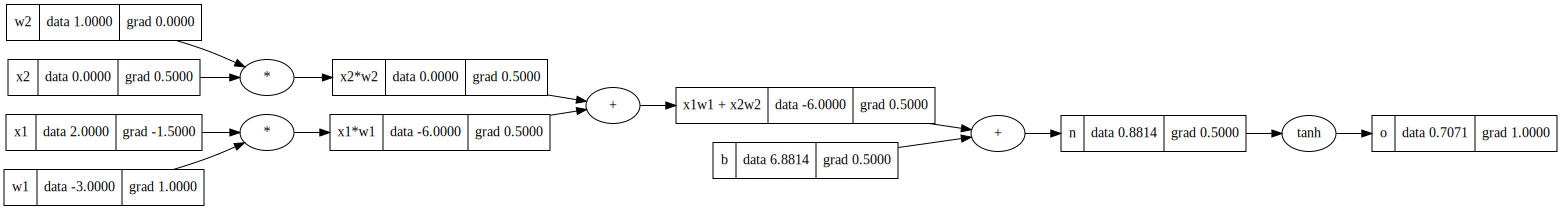

In [6]:
draw_dot(o)

In [7]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
#-------
e = (2*n).exp()
o = (e-1)/(e+1)
#------
o.label='o'
o.backward()

In [8]:
import torch

In [9]:
# using pytorch for the same purpose
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
import random

class Nueron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.nuerons = [Nueron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.nuerons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for nueron in self.nuerons for p in nueron.parameters()]

    # another way of writing this return
    # params = []
    # for nueron in self.nuerons:
    #   ps = nueron.parameters()
    #   params.extend(ps)
    # return params
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data = 0.5225604575653379)

In [12]:
# dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired target


In [13]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss  = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data+= -0.05*p.grad

  print(k,loss.data)

0 4.188096096273572
1 2.5449423077575193
2 1.627398747619973
3 1.07338032445407
4 0.7255011147735074
5 0.5106185884721826
6 0.3754253823104339
7 0.28740476852638963
8 0.22778876255547767
9 0.18582320707706113
10 0.15523074867073453
11 0.13223516665904092
12 0.11448649869071215
13 0.1004722918234422
14 0.08918786869406731
15 0.07994630071634568
16 0.0722655214657687
17 0.06579923582441304
18 0.06029342214054091
19 0.055558218380780566


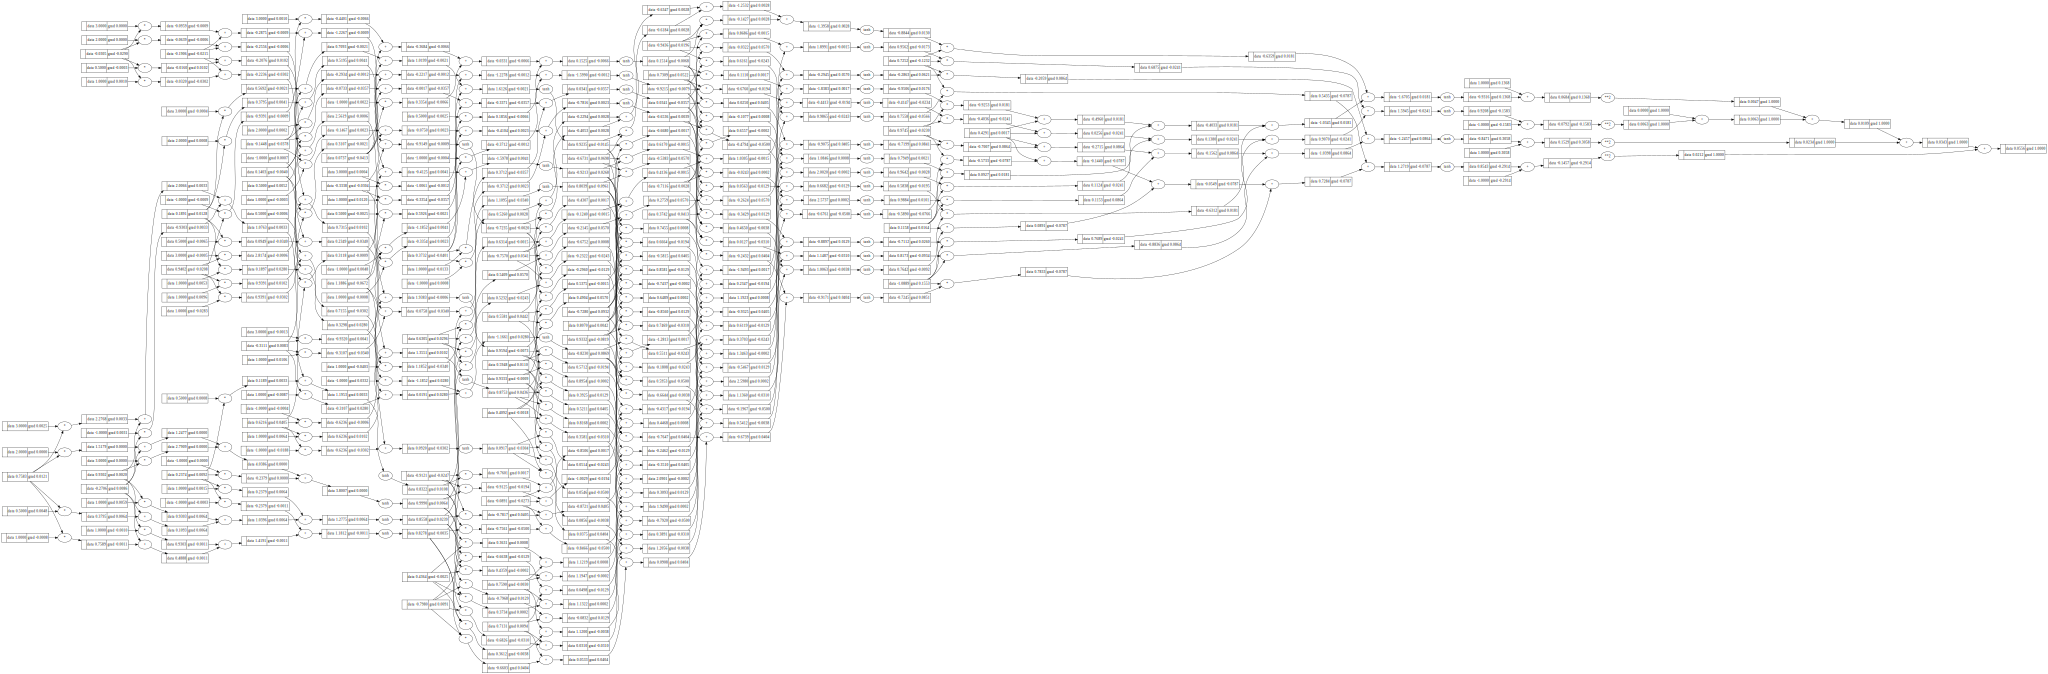

In [15]:
draw_dot(loss)

In [14]:
ypred

[Value(data = 0.9208332124920671),
 Value(data = -0.9316141743161297),
 Value(data = -0.8470758818545322),
 Value(data = 0.8543002022258759)]

In [ ]:
# # full dataset (features + labels)
# xs = [
#     [2.0, 3.0, -1.0],
#     [3.0, -1.0, 0.5],
#     [0.5, 1.0, 1.0],
#     [1.0, 1.0, -1.0],
#     [2.2, 2.9, -1.1],
#     [3.1, -0.9, 0.4],
#     [0.4, 1.2, 0.9],
#     [1.2, 0.9, -0.8],
#     [2.5, 3.5, -1.3],
#     [3.3, -1.2, 0.7],
#     [0.6, 0.8, 1.1],
#     [1.1, 1.3, -0.7],
# ]

# ys = [
#     1.0, -1.0, -1.0, 1.0,   # original 4 points
#     1.0, -1.0, -1.0, 1.0,   # close variants
#     1.0, -1.0, -1.0, 1.0    # more variants
# ]


In [ ]:
# # Training set (first 8)
# x_train = xs[:8]
# y_train = ys[:8]

# # Testing set (last 4)
# x_test = xs[8:]
# y_test = ys[8:]


In [ ]:
# for k in range(20):
#   # forward pass
#   ypred = [n(x) for x in x_train]
#   loss  = sum((yout-ygt)**2 for ygt, yout in zip(y_train, ypred))

#   # backward pass
#   for p in n.parameters():
#     p.grad = 0.0
#   loss.backward()

#   # update
#   for p in n.parameters():
#     p.data+= -1*p.grad

#   print(k,loss.data)

In [ ]:
# y_train

In [ ]:
# ypred

# topological sort for automating backpropagation
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo
    

# o = tanh(n)
# do/dn = 1- o**2

 # isuue in this backporpagation is when neuron is used multiple times it will override it instead of adding it

# to correct this problem we have to change = to += so it will add the new value to previous instead of overriding it